In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
from tqdm import tqdm

# Verify TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Ensure memory growth is enabled for your GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [3]:
NOISE_DIM = 100
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 12500
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 3

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.5, epsilon=1e-07)

# Loading and Preprocessing the Images

In [4]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "/kaggle/input/alzheimer-mri-dataset/Dataset"

##  Name of classes
CLASSES = ['Mild_Demented',
           'Moderate_Demented',
           'Non_Demented',
           'Very_Mild_Demented']

class_counts = {cls: 0 for cls in CLASSES}

# Loop through each class subdirectory and count the number of samples
for cls in CLASSES:
    class_path = os.path.join(WORKING_DIRECTORY, cls)
    class_counts[cls] = len(os.listdir(class_path))

In [5]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0,
                             rotation_range=15,
                             zoom_range=[0.9, 1.1])

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, 
                                            target_size=(128, 128),
                                            batch_size=6400, 
                                            shuffle=True, 
                                            class_mode='categorical')

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


## Plotting The Real Images

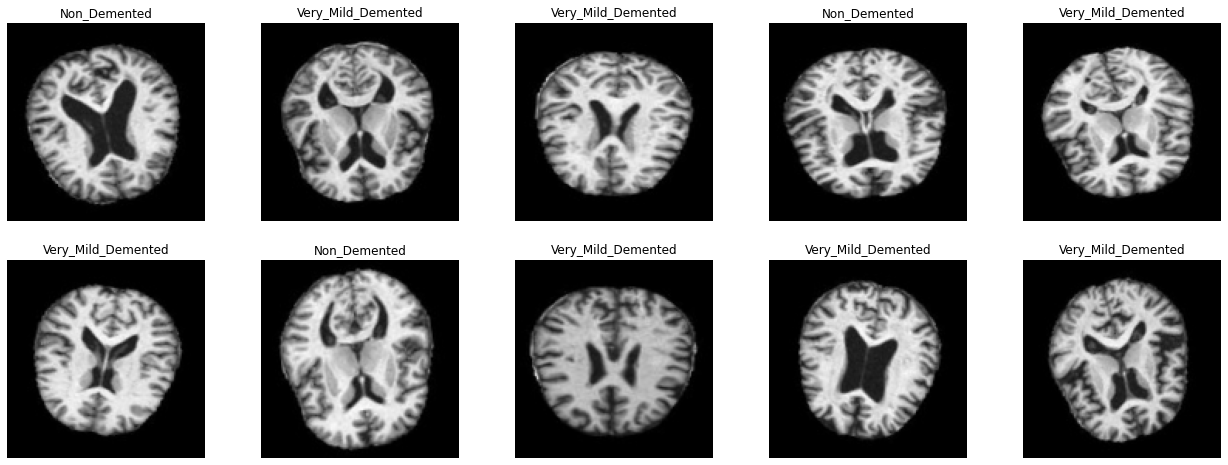

In [6]:
plt.figure(figsize=(22,8))

for images,labels in train_dataset:
#     print(images)
#     print(len(labels))
    for i in range(10):
        ax=plt.subplot(2,5,i+1)
        plt.imshow(images[i])
        plt.title(CLASSES[np.argmax(labels[i])])
        plt.axis("off")
    break

# The Architecture

In [7]:
def build_generator():
    model = Sequential([
        Dense(32 * 32 * 256, input_dim=100),
        LeakyReLU(alpha=0.2),
        Reshape((32, 32, 256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [8]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model


# Putting it together

In [9]:
discriminator = build_discriminator()
generator = build_generator()

discriminator.trainable = False

gan_input = Input(shape=(100,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)     

In [10]:
def sample_images(noise, subplots, figsize=(22, 8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i + 1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save:
            img_name = "gen" + str(i) + ".png"
            plt.imsave(img_name, (image * 127.5 + 127.5).astype(np.uint8))
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


## The Training

100%|██████████| 12500/12500 [17:16<00:00, 12.06it/s]


EPOCH: 1 Generator Loss: 1.9201 Discriminator Loss: 0.6273


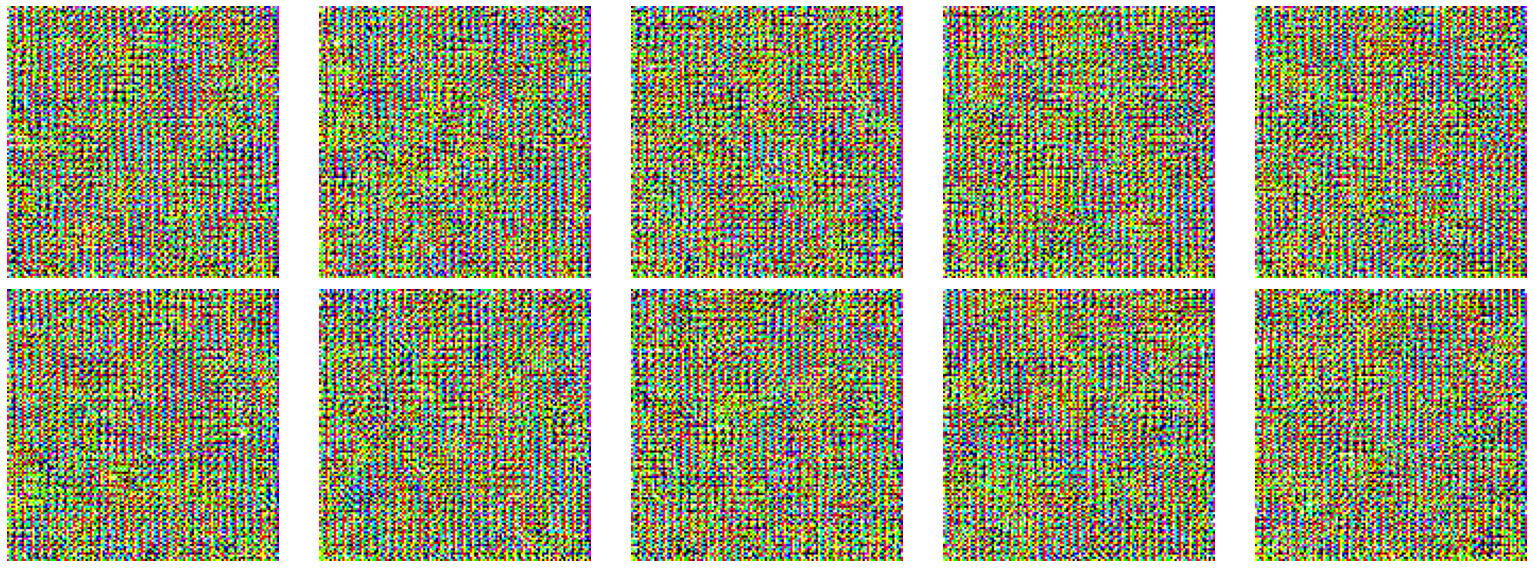

100%|██████████| 12500/12500 [17:10<00:00, 12.12it/s]


EPOCH: 2 Generator Loss: 0.8469 Discriminator Loss: 0.7370


100%|██████████| 12500/12500 [17:14<00:00, 12.08it/s]


EPOCH: 3 Generator Loss: 0.9601 Discriminator Loss: 0.6193


100%|██████████| 12500/12500 [17:24<00:00, 11.97it/s]


EPOCH: 4 Generator Loss: 0.9145 Discriminator Loss: 0.7052


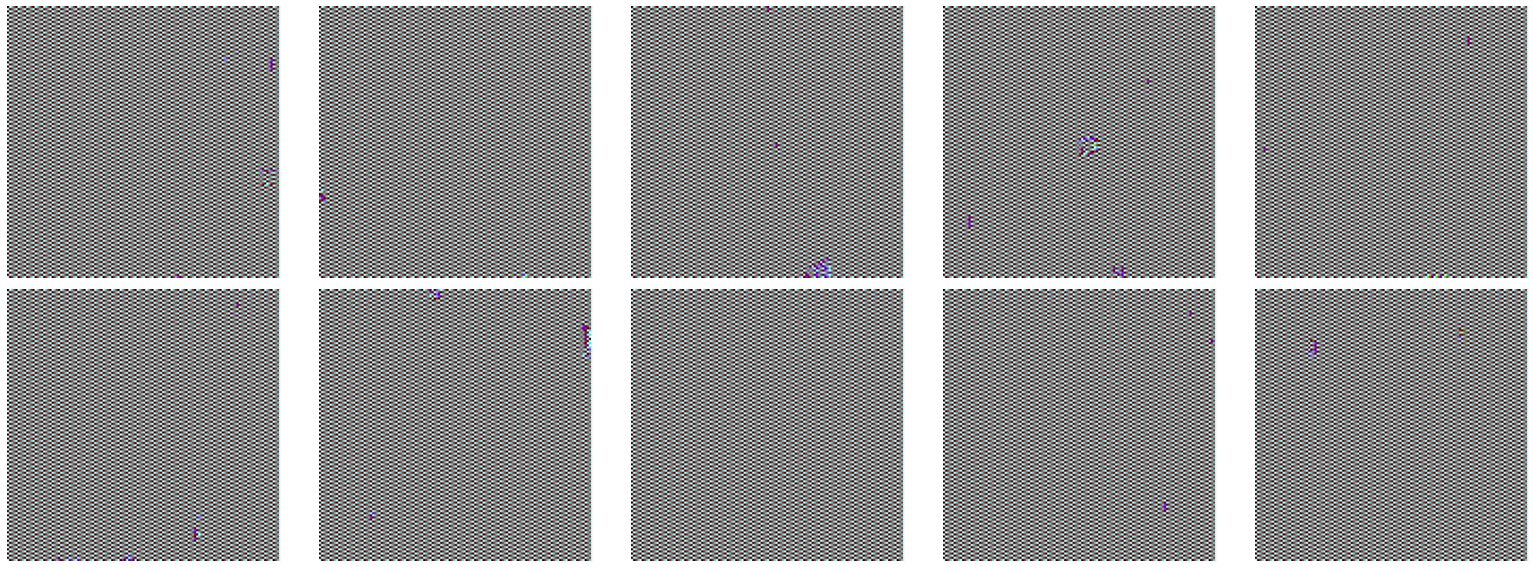

100%|██████████| 12500/12500 [17:24<00:00, 11.97it/s]


EPOCH: 5 Generator Loss: 0.3817 Discriminator Loss: 0.4940


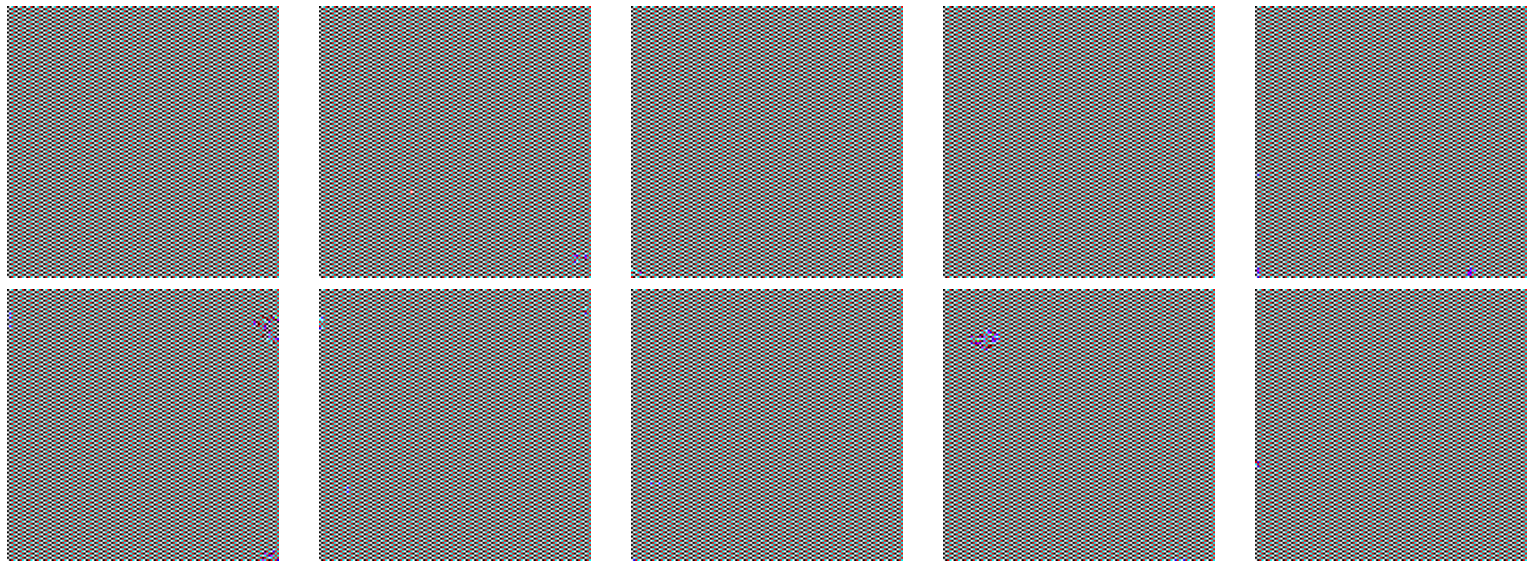

100%|██████████| 12500/12500 [17:32<00:00, 11.88it/s]


EPOCH: 6 Generator Loss: 1.0334 Discriminator Loss: 0.8109


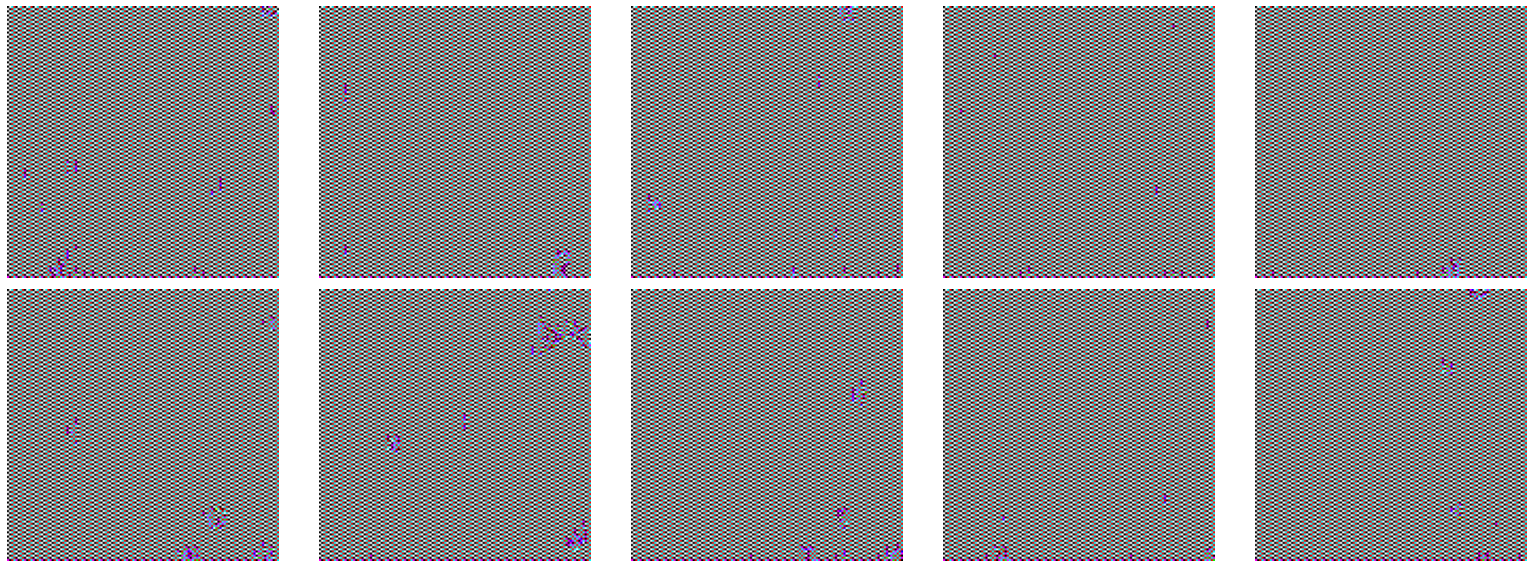

100%|██████████| 12500/12500 [17:40<00:00, 11.79it/s]


EPOCH: 7 Generator Loss: 0.5611 Discriminator Loss: 0.8109


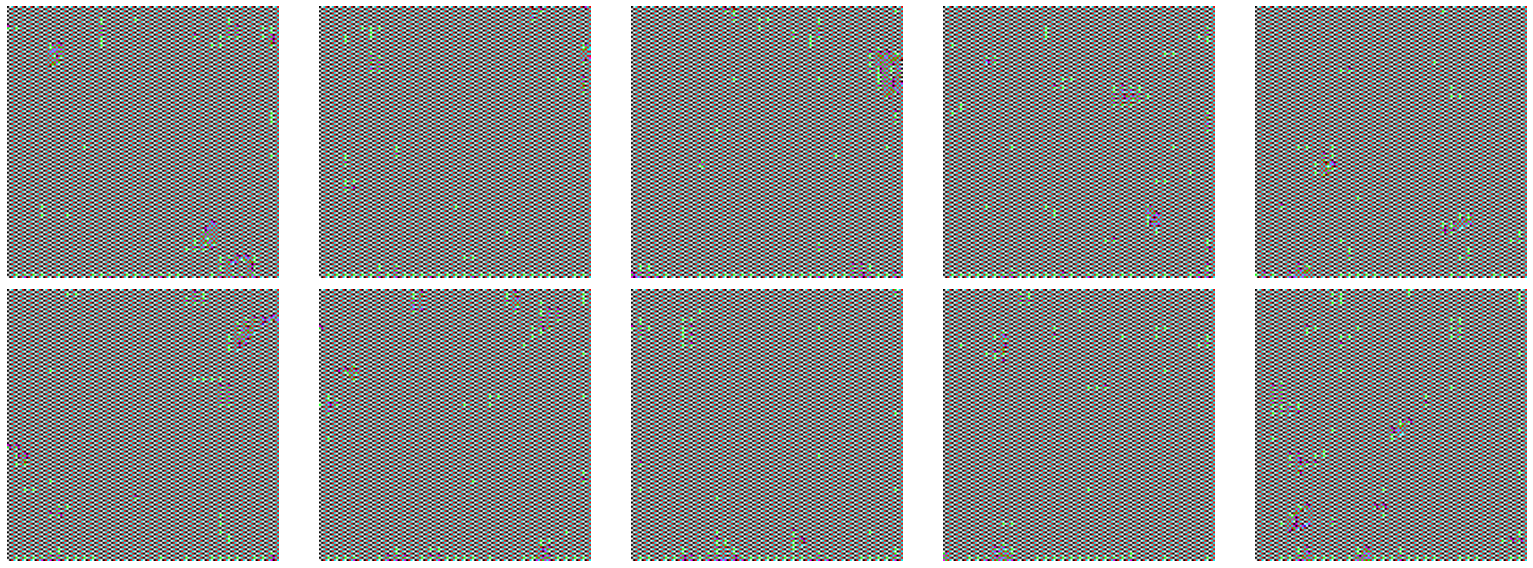

100%|██████████| 12500/12500 [17:48<00:00, 11.70it/s]


EPOCH: 8 Generator Loss: 1.0502 Discriminator Loss: 0.9757


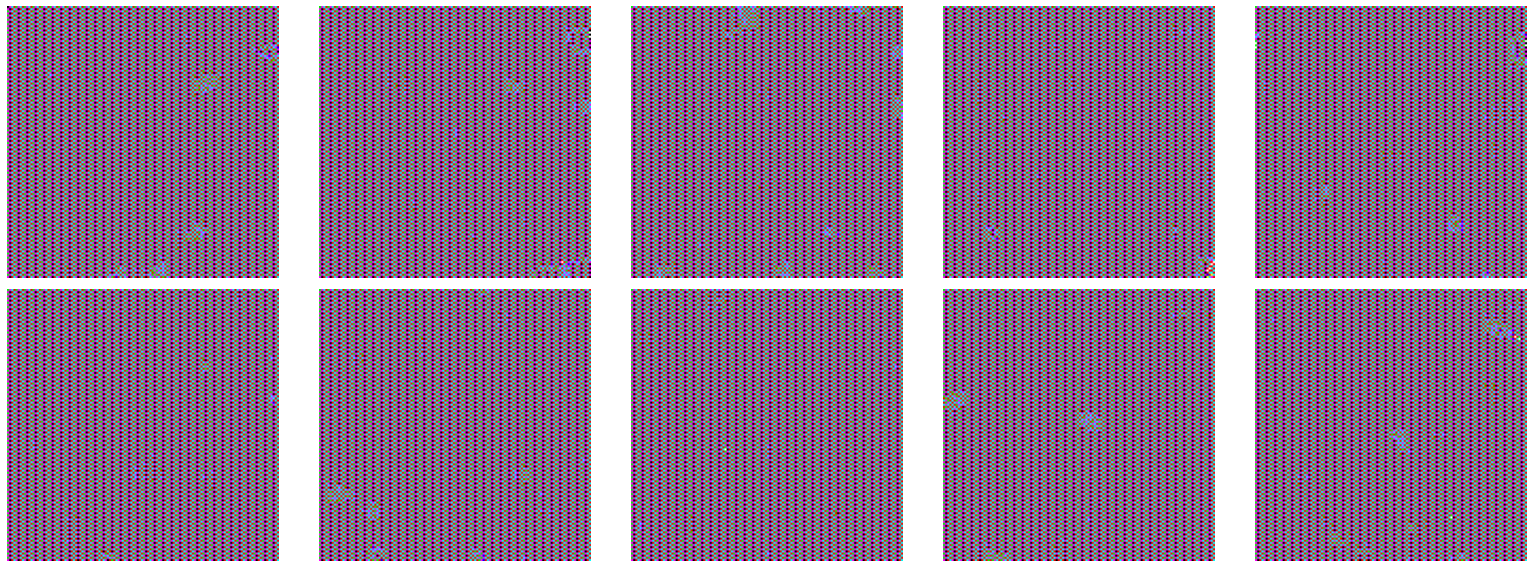

100%|██████████| 12500/12500 [17:50<00:00, 11.68it/s]


EPOCH: 9 Generator Loss: 0.4143 Discriminator Loss: 0.6266


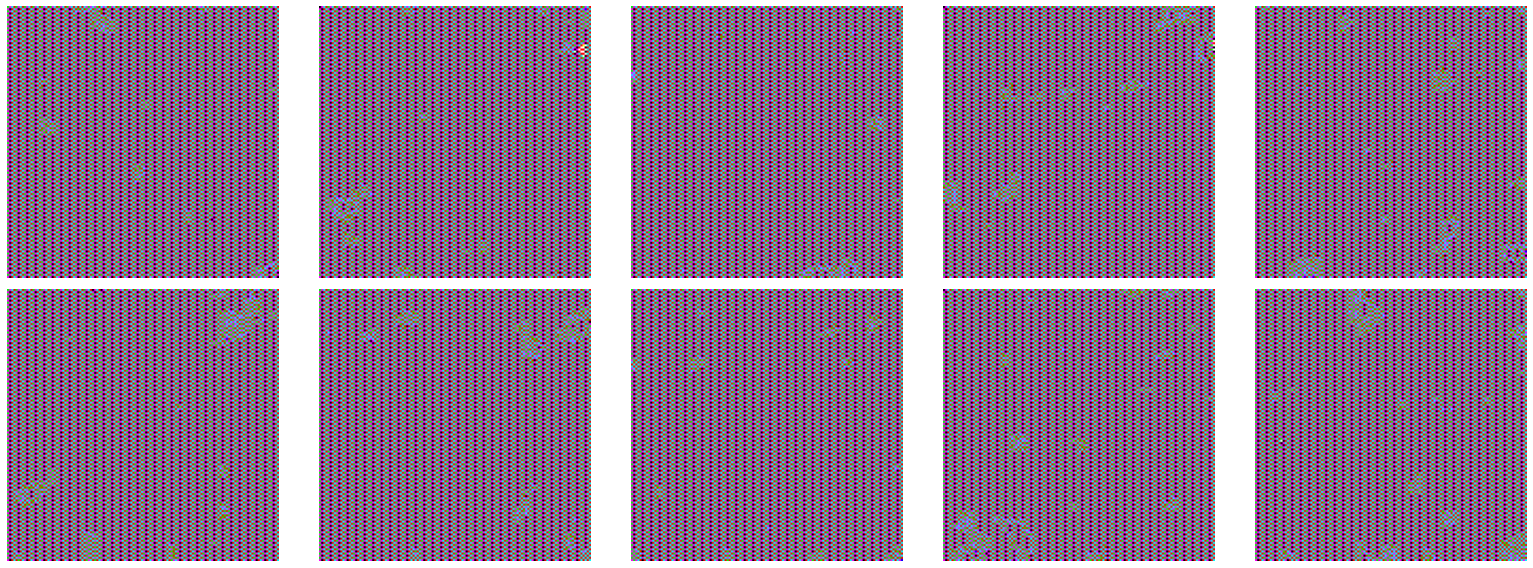

100%|██████████| 12500/12500 [18:32<00:00, 11.23it/s]


EPOCH: 10 Generator Loss: 0.6415 Discriminator Loss: 0.5941


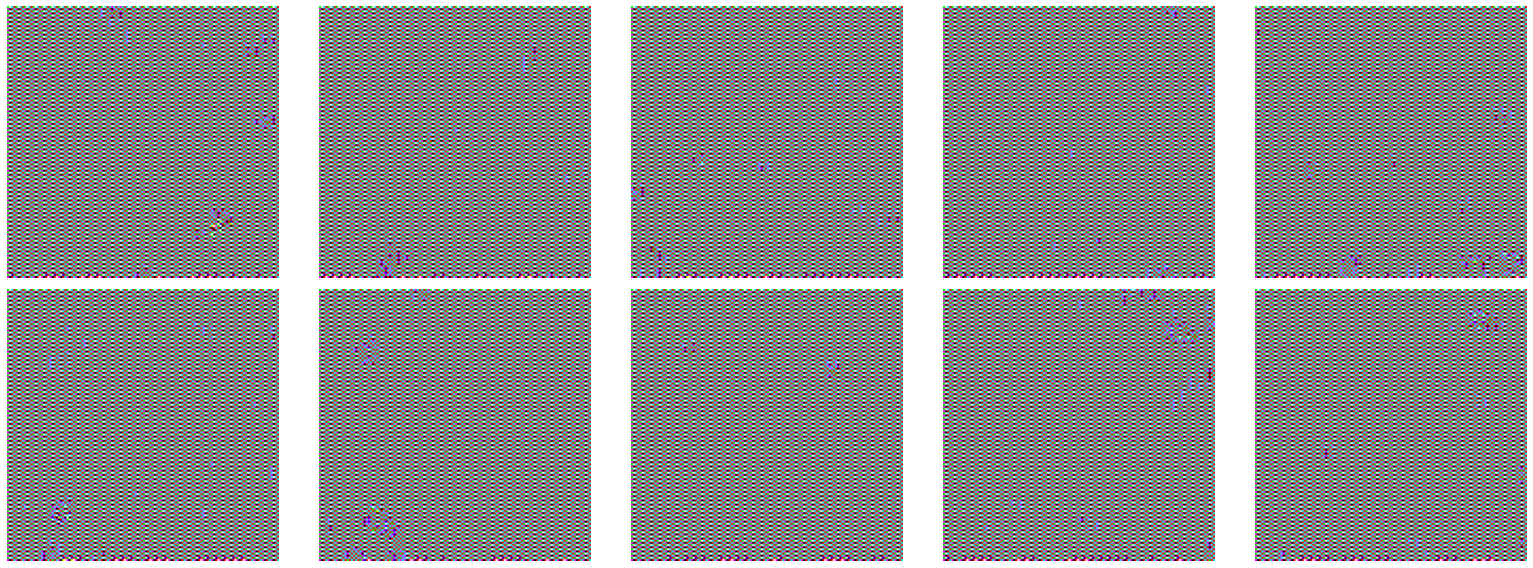

In [11]:
np.random.seed(SEED)
for epoch in range(EPOCHS):
   
    for batch in tqdm(range(STEPS_PER_EPOCH)):
        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X.shape[0], size=BATCH_SIZE)
        real_X = X[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))


# Let's generate some images !

In [12]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10, 10), (24, 20), save=True)

# Testing the Generated sample: Plotting the Distributions

<p style="font-size:20px">In this test, we compare the generated images with the real samples by plotting their distributions. If the distributions overlap, that indicates the generated samples are very close to the real ones
</p>

NameError: name 'X_train' is not defined

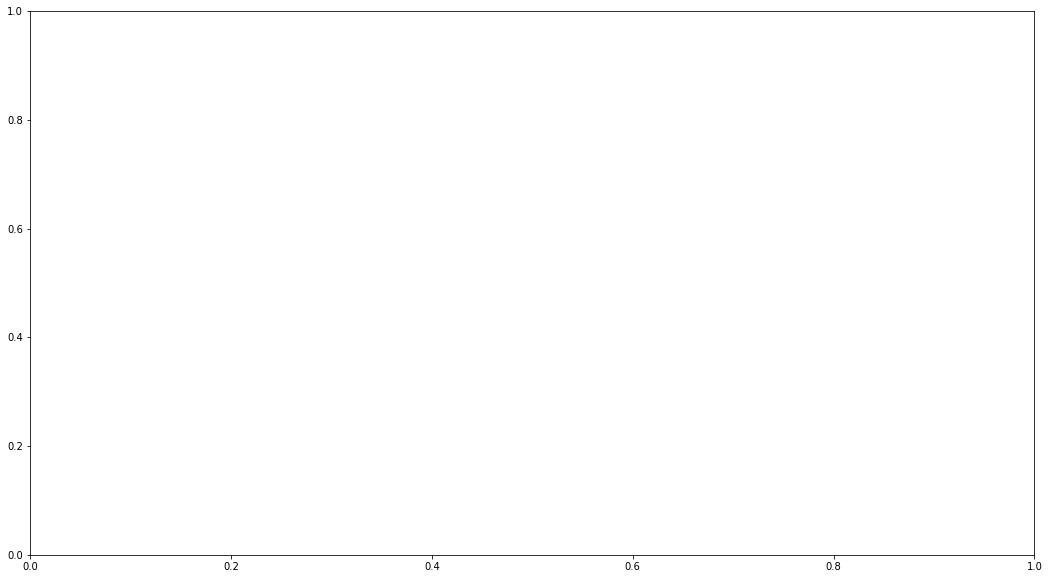

In [13]:
generated_images = generator.predict(noise)
generated_images.shape

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18, 10))

sns.distplot(X_train.flatten(), label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images.flatten(), label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()


In [ ]:
print("ALLDONE")

# References

<p style="font-size:20px">
<ul>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1406.2661">Generative Adversarial Networks</a> (2014)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1606.03498">Improved Techniques for Training GANs</a> (2016)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/2108.03235">SMOTified-GAN for class imbalanced pattern classification problems</a> (2021)</li>
</ul>
</p>